In [1]:
import tabulate
import json
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'Ubuntu'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Inconsolata Medium'
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['figure.figsize'] = (10, 4)

In [2]:
with open("data/qualitative_results.json", "r") as f:
    projects = json.loads(f.read())

In [3]:
# Organize data for visualization
causes = {}
statuses = ["Merged", "Approved", "Pending", "Rejected"]
projects_per_status = {s: set() for s in statuses}  # Track unique projects per status


for project, deps in projects.items():
    for dep, details in deps.items():
        cause = details["Root Cause"]
        status = details["PR Status"]
        if status in statuses:
            if cause not in causes:
                causes[cause] = {s: 0 for s in statuses}
            causes[cause][status] += 1
            projects_per_status[status].add(project)


labels = list(causes.keys())

findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.


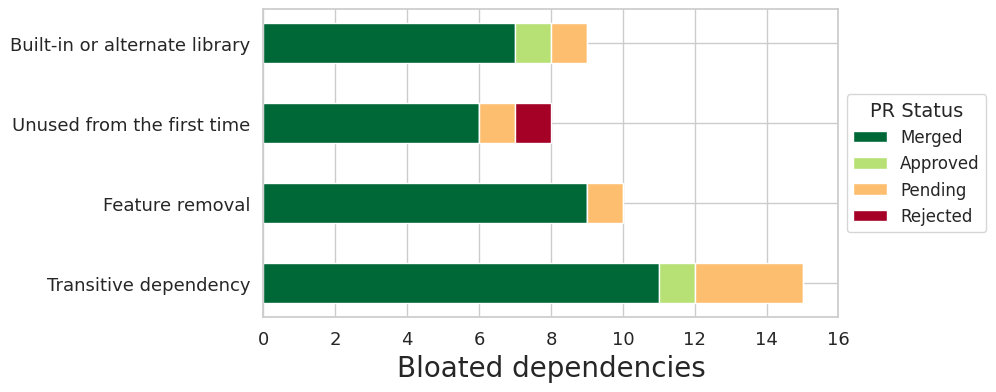

In [4]:
bottom = np.zeros(len(labels))

color_palette = plt.cm.get_cmap('RdYlGn', 4)

# Adjusting the figure size based on the number of labels
fig, ax = plt.subplots(figsize=(10, 4))

for i, status in enumerate(statuses):
    counts = [causes[label][status] for label in labels]
    ax.barh(labels, counts, left=bottom, label=status, height=0.5, color=color_palette((4 - i) / 5))  # Adjust bar thickness with height
    bottom += counts

# Set xlabel with appropriate font size
ax.set_xlabel('Bloated dependencies')

# Create space to the right of the plot
fig.subplots_adjust(right=0.7)

# Adjust the yticks and xticks font sizes

# Set the legend outside the plot on the right
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={"size": 12})
legend.set_title("PR Status", prop={"size": 14})
ax.set_xlim(0, 16)  # Adjust x-axis limits

plt.gca().invert_yaxis() 
plt.savefig("figures/rq4.pdf", bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()


In [5]:
total_prs = sum([len(projects_per_status[status]) for status in statuses])
total_deps_removed = sum([causes[cause][status] for cause in causes for status in statuses])

latex_table = r"""
\begin{table}[h]
\caption{Pull Request (PR) Outcomes for Removal of Bloated Dependencies}
\label{tab:pr_outcomes}
\centering
\resizebox{0.9\linewidth}{!}{
\begin{tabular}{lrr}
\hline
{\bf PR Status} & {\bf Number of PRs} & {\bf Number of Dependencies Removed} \bigstrut\\
\hline
"""

for status in statuses:
    num_prs = len(projects_per_status[status])
    num_deps_removed = sum([causes[cause][status] for cause in causes if status in causes[cause]])
    latex_table += f"{status} & \\nnum{{{num_prs}}} & \\nnum{{{num_deps_removed}}} \\\\\n" 

latex_table += f"\\hline\nTotal & \\nnum{{{total_prs}}} & \\nnum{{{total_deps_removed}}} \\bigstrut \\\\\n\\hline\n"

latex_table += r"""
\end{tabular}}
\end{table}
"""

with open("tables/rq4_pr_status.tex", "w") as file:
    file.write(latex_table)




In [6]:
# Assuming projects are loaded correctly from "data/qualitative_results.json"
with open("data/qualitative_results.json", "r") as f:
    projects = json.loads(f.read())

# Organize data for visualization
causes = {}
statuses = ["Merged", "Approved", "Pending", "Rejected"]
projects_per_status = {s: set() for s in statuses}  # Track unique projects per status
transitive_deps_per_status = {s: 0 for s in statuses}  # New: Track transitive dependencies per status

for project, deps in projects.items():
    for dep, details in deps.items():
        cause = details["Root Cause"]
        status = details["PR Status"]
        if status in statuses:
            if cause not in causes:
                causes[cause] = {s: 0 for s in statuses}
            causes[cause][status] += 1
            projects_per_status[status].add(project)
            # Accumulate the number of transitive dependencies removed
            transitive_deps_per_status[status] += len(details.get("Transitive Dependencies", []))

labels = list(causes.keys())
total_prs = sum([len(projects_per_status[status]) for status in statuses])
total_deps_removed = sum([causes[cause][status] for cause in causes for status in statuses])
# New: Calculate the total number of transitive dependencies removed
total_transitive_deps_removed = sum(transitive_deps_per_status.values())

latex_table = r"""
\begin{table}[h]
\caption{Pull Request (PR) Outcomes for Removal of Bloated Dependencies}
\label{tab:pr_outcomes}
\centering
\resizebox{\textwidth}{!}{
\begin{tabular}{lrrr}
\hline
{\bf PR Status} & {\bf Number of PRs} & {\bf Number of Dependencies Removed} & {\bf Transitive Dependencies Removed} \bigstrut\\
\hline
"""

for status in statuses:
    num_prs = len(projects_per_status[status])
    num_deps_removed = sum([causes[cause][status] for cause in causes if status in causes[cause]])
    num_transitive_deps_removed = transitive_deps_per_status[status]
    latex_table += f"{status} & \\nnum{{{num_prs}}} & \\nnum{{{num_deps_removed}}} & \\nnum{{{num_transitive_deps_removed}}} \\\\\n" 

latex_table += f"\\hline\nTotal & \\nnum{{{total_prs}}} & \\nnum{{{total_deps_removed}}} & \\nnum{{{total_transitive_deps_removed}}} \\bigstrut \\\\\n\\hline\n"

latex_table += r"""
\end{tabular}}
\end{table}
"""

with open("tables/rq4_pr_status_new.tex", "w") as file:
    file.write(latex_table)

In [7]:
import json
from datetime import datetime, timedelta

# Load the JSON data into a Python dictionary
with open('data/qualitative_results.json', 'r') as json_file:
    data = json.load(json_file)

# Create lists to store merged_at dates
same_date = set()
within_week = set()
within_month = set()

remaining = set()

# Convert string dates to datetime objects and categorize PRs
for repo, pr_data in data.items():
    for pr, pr_info in pr_data.items():
        duration = pr_info.get('Duration', -111)
        if duration>=0:
            if duration <1:
                same_date.add(repo)
            elif duration < 8:
                within_week.add(repo)
            elif duration < 32:
                within_month.add(repo)
            else:
                remaining.add(repo)

# Output the results
print("Pull Requests Merged on the Same Date:", len(same_date))
print("Pull Requests Merged Within Week:", len(within_week))
print("Pull Requests Merged Within Month:", len(within_month))
print("Pull Requests Merged more than Month:", len(remaining))


Pull Requests Merged on the Same Date: 5
Pull Requests Merged Within Week: 6
Pull Requests Merged Within Month: 9
Pull Requests Merged more than Month: 7


findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.


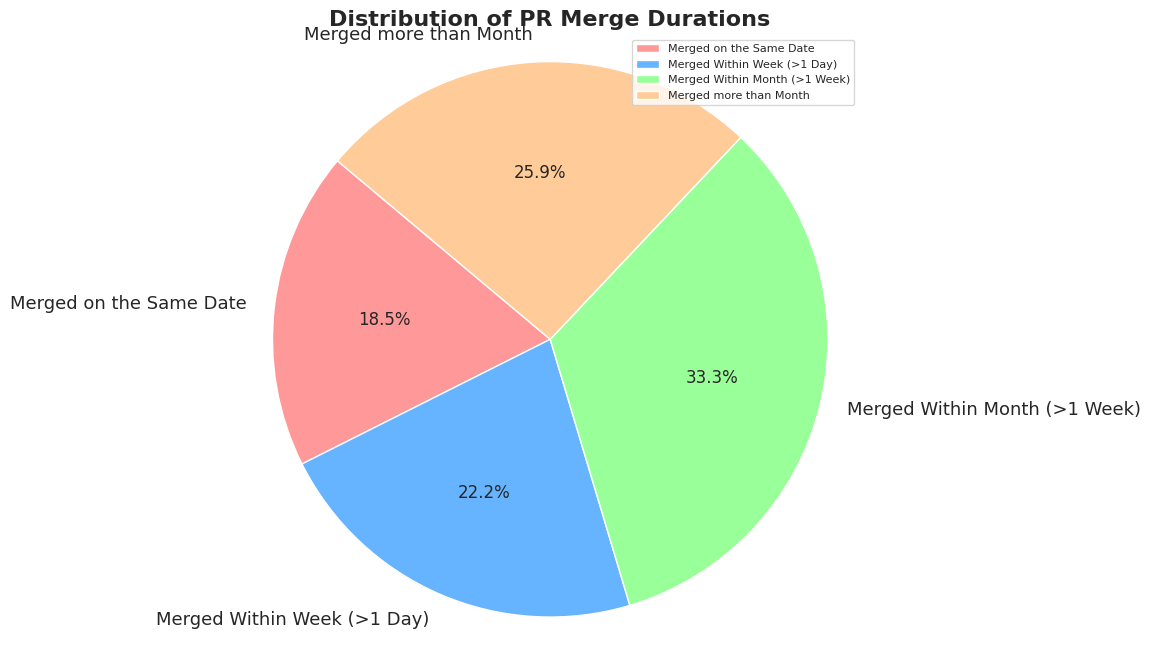

In [8]:
import matplotlib.pyplot as plt

# Data preparation
categories = ['Merged on the Same Date', 'Merged Within Week (>1 Day)', 'Merged Within Month (>1 Week)', 'Merged more than Month']
counts = [5, 6, 9, 7]  # Example counts for each category
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']  # Color for each category

# Explode the 2nd slice (i.e. 'Within Week') to highlight it
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=categories, colors=colors, autopct='%1.1f%%', startangle=140)

# Add a title
plt.title('Distribution of PR Merge Durations', fontsize=16, fontweight='bold')

# Add clarification in the legend or as a note
plt.legend( loc="best", fontsize=8)

# Show the plot
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


27 merged_at

no comments: 3
discussion: 2
conributingguidelines/tests:
thanks: 22 (3 discussion) (7 tests)


 discussion (no contribution) 
https://github.com/EasyPost/easypost-python/pull/294
disucssion (revert noe of changes)
https://github.com/SDXorg/pysd/pull/423
https://github.com/kivy/kivy-ios/pull/840
https://github.com/SasView/sasview/pull/2585
discussion (test failing) (no contribution)
https://github.com/ably/ably-python/pull/526
https://github.com/Juniper/py-junos-eznc/pull/1257
https://github.com/django-helpdesk/django-helpdesk/pull/1112
discussion (filll contributing guidelines) contribution
https://github.com/openedx/edx-drf-extensions/pull/377
https://github.com/4dn-dcic/tibanna/pull/393



Summary of Pull Request Discussions:
-------------------------------------
Total Pull Requests Merged: 27

1. Merged without any discussion: 18
2. Discussions without requested changes: 1
3. Discussions with requested modifications to changed files: 3
4. Discussions regarding failing tests, not attributable to the PR: 3
5. Discussions requesting changes related to contributing guidelines (e.g., fill SLA agreement): 2


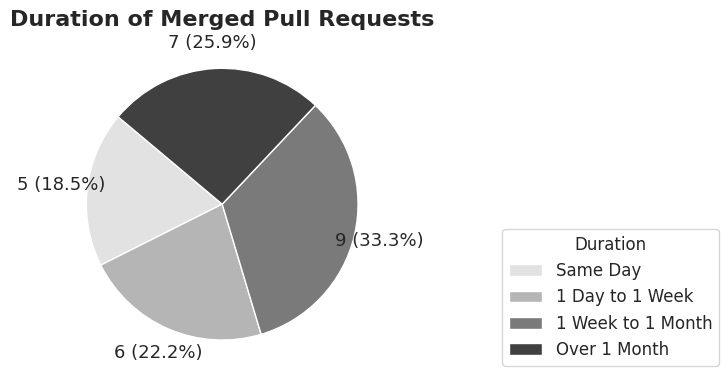

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setup for Duration
colors_durations = sns.color_palette("Greys", 4)
duration_categories = ['Same Day', '1 Day to 1 Week', '1 Week to 1 Month', 'Over 1 Month']
duration_counts = [5, 6, 9, 7]

# Custom autopct function
def custom_autopct(counts):
    def autopct(pct):
        total = sum(counts)
        absolute = int(round(pct*total/100.0))
        return f"{absolute} ({pct:.1f}%)"
    return autopct


# Pie chart for PR Merge Durations
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(duration_counts, startangle=140, colors=colors_durations, autopct=custom_autopct(duration_counts), pctdistance=1.19)
# Increase font size for the numbers in pie chart
for autotext in autotexts:
    autotext.set_fontsize(13)  # Adjust this value as needed
ax.set_title('Duration of Merged Pull Requests', fontsize=16, fontweight='bold')
ax.legend(wedges, duration_categories, title="Duration", loc="lower left", bbox_to_anchor=(1.3, 0, 0.5, 1), prop={"size": 12})

plt.tight_layout()
plt.savefig("figures/rq4b1.pdf", format="pdf", bbox_inches='tight')


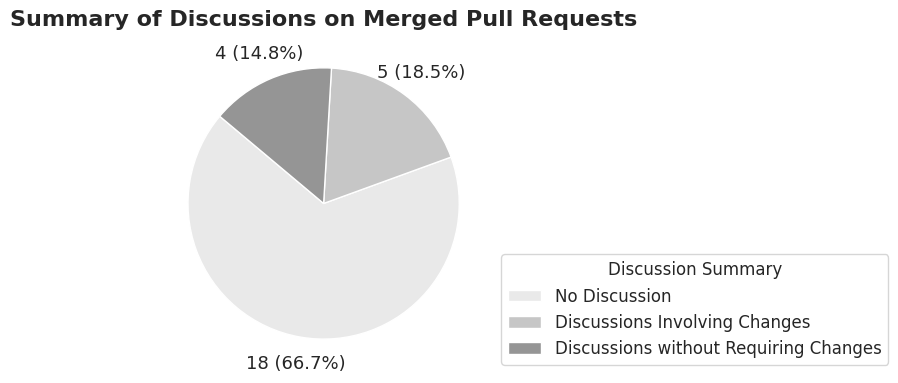

In [10]:
# Setup for Discussion
colors_discussions = sns.color_palette("Greys", 5)
discussion_categories = ['No Discussion', 'Discussions Involving Changes', 'Discussions without Requiring Changes']
discussion_counts = [18, 5, 4]

# Pie chart for PR Discussion Summary
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(discussion_counts, startangle=140, colors=colors_discussions, autopct=custom_autopct(discussion_counts), pctdistance=1.2)
ax.set_title('Summary of Discussions on Merged Pull Requests', fontsize=16, fontweight='bold')
ax.legend(wedges, discussion_categories, title="Discussion Summary", loc="lower left", bbox_to_anchor=(1, 0, 0.5, 1), prop={"size": 12})
for autotext in autotexts:
    autotext.set_fontsize(13)  # Adjust this value as needed
plt.tight_layout()
plt.savefig("figures/rq4b2.pdf", format="pdf", bbox_inches='tight')
